In [3]:
%cd /home/mkallel/explo/

import logging
import logging.config
import os
from multiprocessing import Pool
from warnings import simplefilter

import gpytorch
import numpy as np
import torch
import threading
import wandb
from src.config import get_configs
from src.helpers import setup_experiment
from src.trainer import Trainer
import itertools


logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

simplefilter(action='ignore', category=DeprecationWarning)
#os.environ["WANDB_API_KEY"]="28996bd59f1ba2c5a8c3f2cc23d8673c327ae230"
os.environ["WANDB_API_KEY"]="baf5048ab2de89a0b2cea751b1b28ff2bfa4c782"

def run(seed,
        env_name,
        kernel_name,
        manipulate_state,
        norm_grad,
        conf_grad,
        advantage_mean,
        adaptive_lr,
        lr ):

        #env_name = "CartPole-v1" ## Action kernel + State_norm looks very well for cartpole
        #env_name = "Swimmer-v4" ##  State_norm stabilizes training 
        #env_name = "Hopper-v2"
        #env_name = "HalfCheetah-v2"        
        #env_name = "Walker2d-v3"

        project_name = env_name+("RBFSTATE + CONF")
        run_name =  kernel_name+"_lr="+str(lr) +"_"+str(1 *manipulate_state)+ str(1 *norm_grad) + str(1 *conf_grad) + str(1 *advantage_mean)+str(1 *adaptive_lr) +"_"+ str(seed)
        env_config,policy_config,likelihood_config,kernel_config,mean_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name,
        use_ard=True,manipulate_state=manipulate_state,
        conf_grad=conf_grad,norm_grad=norm_grad,advantage_mean=advantage_mean,adaptive_lr=adaptive_lr,lr=lr,
        wandb_logger=False,project_name=project_name,run_name=run_name)

        trainer_config["n_steps"]=500

        model,objective_env,optimizer = setup_experiment(env_config,mean_config,kernel_config,likelihood_config,policy_config,optimizer_config,
                                        seed=seed)

        trainer = Trainer(model,objective_env,optimizer,**trainer_config)
        trainer.run()

        return model,objective_env,optimizer



if __name__ == '__main__':

        
        wandb.require("service")
        wandb.setup()  

        env_name = ["Swimmer-v4"]
        #env_name = ["CartPole-v1"]
        kernel_name = ["rbfstate"]
        manipulate_state = [False]
        norm_grad = [True]
        conf_grad = [True] ##run this for rbf
        advantage_mean = [True]
        adaptive_lr = [False]
        learning_rate = 0.1 if kernel_name == ["rbfstate"] else 0.5
        lr = [learning_rate]

        for config in itertools.product(*[env_name,kernel_name,manipulate_state,norm_grad,conf_grad,advantage_mean,adaptive_lr,lr]):

        
                model,objective_env,optimizer = run(*(0,*config))



/home/mkallel/explo
MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]
MLPPPPPPPPP SETUP 18
MLP LEEEEEN 18
 Gibo will use 32 last points to fit GP and 16 info samples
fixing seed to  0


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/torch/autograd/__init__.py:275: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATe

0.5555555555555556
MLL : -75.75869750976562
batch_mean 0.004638348240405321 batch_max 0.22266651690006256
0.3888888888888889
MLL : -38.60270309448242
batch_mean 0.003214934142306447 batch_max 0.22266651690006256
0.5555555555555556
MLL : -27.545913696289062
batch_mean 0.019361987709999084 batch_max 0.32643699645996094
0.7777777777777778
MLL : -27.611679077148438
batch_mean 0.02797144651412964 batch_max 0.32643699645996094
0.7222222222222222
MLL : -27.71497344970703
batch_mean 0.042711544781923294 batch_max 0.32643699645996094
0.5555555555555556
MLL : -27.714811325073242
batch_mean 0.03505690395832062 batch_max 0.2682105004787445
0.6111111111111112
MLL : -27.733613967895508
batch_mean 0.034021589905023575 batch_max 0.2947036623954773
0.5
MLL : -27.544572830200195
batch_mean 0.033223722130060196 batch_max 0.2947036623954773
0.5555555555555556
MLL : -27.562376022338867
batch_mean 0.041303057223558426 batch_max 0.2947036623954773
0.4444444444444444
MLL : -27.523725509643555
batch_mean 0.042

In [4]:
# PATH = "/home/mkallel/explo/models/Swimmer"
# dict = model.state_dict()
# dict.update({
#     "optimizer":optimizer,
#     #"objective_env":objective_env,
#     })
# torch.save(dict,PATH)

Generating data
Done generating data
matplotlib.legend : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


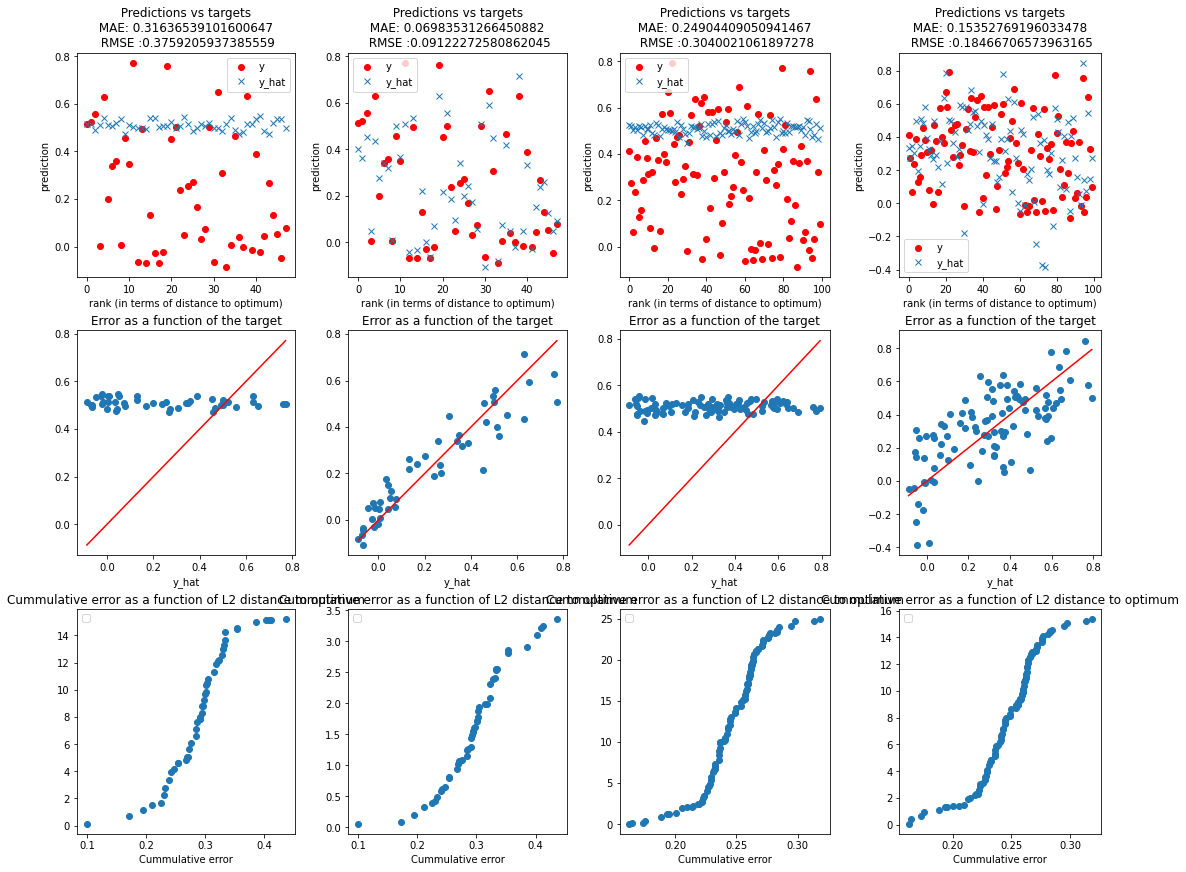

In [5]:
import pickle
import random

import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


##fix random seed
random.seed(0)
torch.manual_seed(0)

class Tester:
    
    def __init__(self,model,objective_env,local_opt,
                 delta=0.1,n_test=100,n_episodes_test=2,
                 ):
        
        
        self.__dict__.update(locals())
        
        
        

       
    def generate_data(self,n_test,n_episodes_test):
        
        objective_env,delta= self.objective_env,self.delta
        
        
        print(f'Generating data')
        
        
        bounds = torch.tensor([[-delta], [delta]]) + self.local_opt
        U = torch.distributions.Uniform(bounds[0],bounds[1])
        test_x = U.sample(sample_shape=[n_test])
        test_y = [objective_env(x.reshape(1,-1),n_episodes_test)[0] for x in test_x] ## run test points multiple times to get real value

        print(f'Done generating data')

        return test_x,torch.tensor(test_y)
        
    
  
  
    def plot(self,x,y,y_hat,local_x,title,
             subfigure=None):
    
        
        ### arrange points by l2 distance to optimum
        dist = torch.linalg.norm(x-local_x,dim=1)
        idx = torch.argsort(dist)
 
        y = y[idx]
        y_hat = y_hat[idx]
        x_plot = range(len(y))
        
        if subfigure is None:
            fig,axs = plt.subplots(3,figsize=(5,12))

        else :
            axs = subfigure.subplots(3)
            
        axs[0].scatter(x_plot,y,label="y",color="red")
        axs[0].errorbar(x_plot,y_hat,label="y_hat",fmt="x")
        axs[0].title.set_text(f' Predictions vs targets \n MAE: {mae(y,y_hat)} \n RMSE :{mse(y,y_hat,squared=False)}')
        axs[0].set_xlabel("rank (in terms of distance to optimum)")
        axs[0].set_ylabel("prediction")
        
        axs[0].legend()
        
        idx2 = torch.argsort(y)
        axs[1].scatter(y[idx2],y_hat[idx2],label="error")
        axs[1].plot(y[idx2],y[idx2],color="red")
        axs[1].title.set_text("Error as a function of the target")
        axs[1].set_xlabel("y")
        axs[1].set_xlabel("y_hat")
        
        error = torch.abs(y[idx]-y_hat[idx])
        axs[2].scatter(dist[idx],torch.cumsum(error,dim=0))
        axs[2].set_title("Cummulative error as a function of L2 distance to optimum")
        axs[2].set_xlabel("||x - x_opt||")
        axs[2].set_xlabel("Cummulative error")
        
        plt.legend()
        
        
    
    def get_mll(self,model,x,y):
        
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
        output = model(x)
        marginal_likelihood = mll(output,y)
        
        return marginal_likelihood.item()
        
    def predict(self,model,x):
        
        model.eval()
        model.likelihood.eval()
        
        with torch.no_grad():

            pred = model.likelihood(model(x))
        
        lower, upper = pred.confidence_region()   
        y_hat = pred.mean  
        
        return y_hat,lower,upper
    
 
    def run(self):
        
        self.__dict__.update(locals()) ##save args to self

        train_x,train_y =  model.train_inputs[0],model.train_targets
        test_x,test_y = self.generate_data(self.n_test,self.n_episodes_test)
        
        train_mean = model.mean_module(train_x).detach().cpu().numpy()
        test_mean = model.mean_module(test_x).detach().cpu().numpy()

        train_pred = self.predict(model,train_x)
        test_pred  = self.predict(model,test_x)
        
        train_mll = self.get_mll(model,train_x,train_y)
        test_mll = self.get_mll(model,test_x,test_y)
        
        
        #fig = plt.figure(constrained_layout=True,figsize=(8,12))
        fig = plt.figure(constrained_layout=True,figsize=(15,12))
        subfigures = fig.subfigures(1,4)
        ### train plots
        
        y_hat,lower,upper = train_pred
        self.plot(train_x,train_y,train_mean,self.local_opt,"train_mean",
                  subfigures[0])
        
        self.plot(train_x,train_y,y_hat,self.local_opt,"train_gp",
                  subfigures[1])
        
        ### test plots
        
        y_hat,lower,upper = test_pred
        self.plot(test_x,test_y,test_mean,self.local_opt,"test_mean",
                  subfigures[2])
        
        self.plot(test_x,test_y,y_hat,self.local_opt,"test_gp",
                  subfigures[3])

tester = Tester(model,objective_env,optimizer.theta_i)
tester.run()

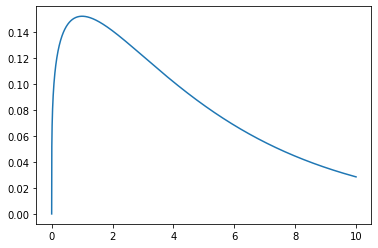

In [6]:
import scipy.stats as stats 
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.25
beta = 0.25
x = np.linspace (0, 10, 2000) 
y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x,y1)